In [1]:
!pip install torchtext==0.18.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.2 MB/s eta 0:00:00


In [2]:
!pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0 --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.9/780.9 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 89.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 83.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 102.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 130.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196

In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
import time
import random

/usr/local/lib/python3.12/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

In [4]:
torch.cuda.is_available()

True

In [5]:
RANDOM_SEED=42
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

VOCAB_SIZE=20000
LEARNING_RATE=0.005
BATCH_SIZE=128
EMBEDDING_DIM=128
NUM_EPOCHS=15
DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
HIDDEN_DIM=256
NUM_CLASSES=2
DEVICE

device(type='cuda')

In [6]:
tokenizer=get_tokenizer('spacy', language='en_core_web_sm')

In [7]:
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

In [8]:
class IMDBCSVDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        if 'review' not in self.data.columns or 'sentiment' not in self.data.columns:
            raise ValueError("CSV file must contain 'review' and 'sentiment' columns.")
        self.data['sentiment'] = self.data['sentiment'].map({'positive': 1, 'negative': 0})

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        review = self.data.iloc[idx]['review']
        sentiment = self.data.iloc[idx]['sentiment']
        return sentiment, review

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
dataset=IMDBCSVDataset('/content/drive/My Drive/IMDB_sentiment_analysis/IMDB Dataset.csv')
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8,0.2])
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.85,0.15])

print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of validation examples: {len(val_dataset)}")
print(f"Number of testing examples: {len(test_dataset)}")

Number of training examples: 34000
Number of validation examples: 6000
Number of testing examples: 10000


In [11]:
vocab = build_vocab_from_iterator(
    yield_tokens(iter(train_dataset)),
    max_tokens=VOCAB_SIZE,
    specials=['<unk>', '<pad>']
)

In [12]:
def text_pipeline(text):
    tokens = tokenizer(text)
    indexed_tokens = [vocab[token] for token in tokens]
    return torch.tensor(indexed_tokens, dtype=torch.long)
def label_pipeline(label):
    return torch.tensor(label, dtype=torch.long)
def collate_fn(batch):
    text_list, label_list = [], []
    for _label, _text in batch:
        label_list.append(_label)
        processed_text = text_pipeline(_text)
        text_list.append(processed_text)
    padded_texts = pad_sequence(text_list, batch_first=True, padding_value=vocab['<pad>'])

    return padded_texts, torch.tensor(label_list)

In [13]:
vocab.set_default_index(vocab['<unk>'])

In [14]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

Training started...
Epoch: 1/15, Loss: 0.5936, Train Accuracy: 86.86%, Validation Accuracy: 84.60%
    --> Validation accuracy improved. Saving model weights.
Time elapsed: 3.41 minutes
Epoch: 2/15, Loss: 0.2693, Train Accuracy: 93.60%, Validation Accuracy: 88.55%
    --> Validation accuracy improved. Saving model weights.
Time elapsed: 6.83 minutes
Epoch: 3/15, Loss: 0.1744, Train Accuracy: 96.60%, Validation Accuracy: 89.22%
    --> Validation accuracy improved. Saving model weights.
Time elapsed: 10.27 minutes
Epoch: 4/15, Loss: 0.1095, Train Accuracy: 98.12%, Validation Accuracy: 89.03%
    --> Validation accuracy did not improve. Patience: 1/5
Time elapsed: 13.71 minutes
Epoch: 5/15, Loss: 0.0672, Train Accuracy: 99.06%, Validation Accuracy: 88.77%
    --> Validation accuracy did not improve. Patience: 2/5
Time elapsed: 17.13 minutes
Epoch: 6/15, Loss: 0.0425, Train Accuracy: 99.28%, Validation Accuracy: 88.58%
    --> Validation accuracy did not improve. Patience: 3/5
Time elapse

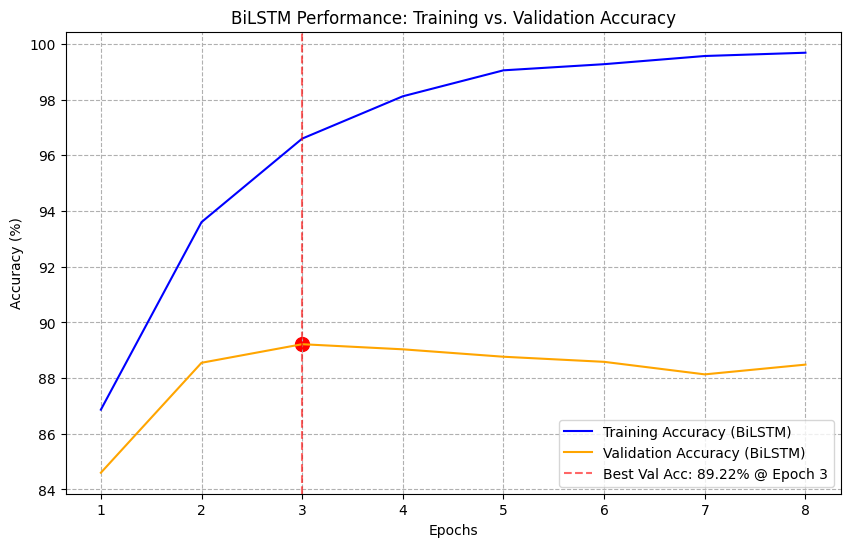

In [15]:
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt

# --- Assume Hyperparameters and Data Loaders are defined here ---
# Example placeholders (YOU MUST DEFINE THESE BASED ON YOUR SETUP):
# RANDOM_SEED = 42
# NUM_EPOCHS = 20
# EMBEDDING_DIM = 100
# HIDDEN_DIM = 256
# NUM_CLASSES = 2  # For binary sentiment classification
# LEARNING_RATE = 1e-4
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# vocab, train_loader, val_loader, test_loader are assumed to be loaded.

# --- 1. BiLSTM Model Definition (FIXED) ---
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, num_layers=1):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)

        # LSTM is correctly defined as bidirectional=True
        self.rnn = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        # CRITICAL FIX: The final linear layer must accept 2 * hidden_dim
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.rnn(embedded)

        # CRITICAL FIX: Concatenate the final forward (hidden[-2]) and
        # backward (hidden[-1]) hidden states to get the full context.
        final_hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)

        out = self.fc(final_hidden)

        return out

# --- 2. Accuracy Function ---
def compute_accuracy(model, data_loader, device):
    # Set model to evaluation mode
    model.eval()
    with torch.no_grad():
        correct_predictions = 0
        total_predictions = 0
        for features, labels in data_loader:
            features = features.to(device)
            labels = labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
    # Set model back to training mode (important for subsequent epochs)
    model.train()
    return correct_predictions * 100.00 / total_predictions

# --- 3. Setup and Training Loop with Early Stopping ---

# torch.manual_seed(RANDOM_SEED) # Uncomment if using a seed

# Instantiate the model
# NOTE: Replace len(vocab), EMBEDDING_DIM, etc. with your actual variable names
model = BiLSTMModel(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES)
model = model.to(DEVICE)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# Early Stopping Parameters
BEST_VAL_ACC = 0.0
PATIENCE = 5  # Stop if no improvement for 5 epochs
PATIENCE_COUNTER = 0

start = time.time()
print("Training started...")

train_accs = []
val_accs = []

for epoch in range(NUM_EPOCHS):
    # Check for early stop at the start of the epoch
    if PATIENCE_COUNTER >= PATIENCE:
        print(f"Stopping early at Epoch {epoch+1} due to no improvement in validation accuracy for {PATIENCE} epochs.")
        break

    model.train()
    epoch_loss = 0

    # --- Training Phase ---
    for i, (features, labels) in enumerate(train_loader):
        features = features.to(DEVICE)
        labels = labels.to(DEVICE).long()

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # --- Evaluation Phase ---
    train_acc = compute_accuracy(model, train_loader, DEVICE)
    val_acc = compute_accuracy(model, val_loader, DEVICE)

    train_accs.append(train_acc) # Populating the list for plotting
    val_accs.append(val_acc)     # Populating the list for plotting

    avg_epoch_loss = epoch_loss / len(train_loader)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS}, Loss: {avg_epoch_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%')

    # --- Early Stopping Logic ---
    if val_acc > BEST_VAL_ACC:
        BEST_VAL_ACC = val_acc
        PATIENCE_COUNTER = 0
        # Save the best model weights
        torch.save(model.state_dict(), 'best_bilstm_weights.pth')
        print(f"    --> Validation accuracy improved. Saving model weights.")
    else:
        PATIENCE_COUNTER += 1
        print(f"    --> Validation accuracy did not improve. Patience: {PATIENCE_COUNTER}/{PATIENCE}")

    print(f'Time elapsed: {(time.time()-start)/60.0:.2f} minutes')

# --- 4. Final Evaluation ---
# Load the best model weights
model.load_state_dict(torch.load('best_bilstm_weights.pth'))

# Final Test Accuracy
test_acc = compute_accuracy(model, test_loader, DEVICE)
print('='*50)
print('Final Model Loaded (from peak validation performance):')
print(f'Test Accuracy: {test_acc:.2f}%')
print('='*50)

# --- 5. Plotting Code ---
print("\nGenerating Accuracy Plot...")
epochs_ran = len(train_accs)
best_epoch_index = val_accs.index(max(val_accs))
best_val_acc = val_accs[best_epoch_index]

plt.figure(figsize=(10, 6))

# Plot Training Accuracy
plt.plot(range(1, epochs_ran + 1), train_accs, label='Training Accuracy (BiLSTM)', color='blue')

# Plot Validation Accuracy
plt.plot(range(1, epochs_ran + 1), val_accs, label='Validation Accuracy (BiLSTM)', color='orange')

# Add a marker for the best validation performance
plt.axvline(x=best_epoch_index + 1, color='red', linestyle='--', alpha=0.6, label=f'Best Val Acc: {best_val_acc:.2f}% @ Epoch {best_epoch_index + 1}')
plt.scatter(best_epoch_index + 1, best_val_acc, color='red', marker='o', s=100)

plt.title('BiLSTM Performance: Training vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')

plt.legend()
plt.grid(True, linestyle='--')
plt.show()

In [16]:
# import matplotlib.pyplot as plt
# plt.plot(range(1, NUM_EPOCHS + 1), train_accs, label='Training Loss')
# plt.plot(range(1, NUM_EPOCHS + 1), val_accs, label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss over Epochs')